# Deep Dream

Using pretrained Inception V3 with Pytorch.

References:

- Basic algorithm and understanding:

    - [Deep Dream TF 2.0](https://www.mlq.ai/deep-dream-with-tensorflow-2-0/)
    - [Deep Dream TF Core](https://www.tensorflow.org/tutorials/generative/deepdream)

- Inception and recursion:

    - [Hacker Noon](https://hackernoon.com/deep-dream-with-tensorflow-a-practical-guide-to-build-your-first-deep-dream-experience-f91df601f479)
    - [Minimal Pytorch Deep Dream](https://github.com/eriklindernoren/PyTorch-Deep-Dream)

In [0]:
%%capture

# whithout scipy==1.3.3 Inceptionv3 takes too long to load
!pip install --upgrade scipy==1.3.3

In [0]:
import glob

import torch
import torchvision
from torchvision import transforms as T
from torch import nn

import cv2
from PIL import Image, ImageFilter

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

from tqdm.notebook import tqdm

## Deep Dream Model

Our Deep Dream model will load the pretrained Inception V3 and register hooks to save the outputs of the given **layers of interest**.

We will call this partial outputs as **features**.

This outputs will be saved into an array to used later to compute the target loss.

First we check which layers we have available as LOI and then we create the Deep Dream Model. Later we'll select which layers we want to use.

In [3]:
dict(torchvision.models.inception_v3(pretrained=True).named_children()).keys()

dict_keys(['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b', 'Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'AuxLogits', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c', 'fc'])

In [0]:
class DeepDream(nn.Module):
    """
    Deep Dream Model:
    Params:
        - loi: layers of interest: names of the layers that will be saved
                with hooks to get their outputs.
    """

    def __init__(self, loi):
        super(DeepDream, self).__init__()

        # load pretrained model
        self.layers = torchvision.models.inception_v3(pretrained=True)

        # prepare hooks
        self.features = []
        self.hooks = []
        for layer in loi:
            s_layer = dict(self.layers.named_children())[layer]
            self.hooks.append(s_layer.register_forward_hook(self.feature_hook))
    
    def feature_hook(self, module, _in, _out):
        self.features.append(_out)
    
    def remove(self):
        [hook.remove() for hook in self.hooks]

    def forward(self, x):
        self.features = []
        return self.layers(x)

## Image Utils

In [0]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMEAN=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
ISTD=[1/0.229, 1/0.224, 1/0.225]
SIZE = 256

preprocess = T.Compose([
    T.Resize(SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD)
])

postprocess = T.Compose([
    T.Normalize(IMEAN, ISTD),
    T.ToPILImage()
])

def clip(image):
    for c, (mean, std) in enumerate(zip(MEAN, STD)):
        image[0, c] = torch.clamp(image[0, c], -mean/std, (1 - mean)/std)
    return image

def scaled(image, factor):
    return image.resize((int(image.width * factor), int(image.height * factor)))

## Loss function

This loss represents the mean sum of the features given in the layers we selected as **interesting**. The objective is to maximize this value by modifying the source image and get some trippy effect.

In [0]:
def deep_dream_loss(model, target):
    # run the image through the net
    _ = deep_dream(target)

    # get the loss
    losses = [torch.mean(act) for act in model.features]
    loss = torch.stack(losses, axis=0).sum()
    return loss

## Algorithm

The first step in the algorithm is to create the **inceptions**, as explained [here](https://hackernoon.com/deep-dream-with-tensorflow-a-practical-guide-to-build-your-first-deep-dream-experience-f91df601f479), if we downsample and blur the image, our layers will recognize larger patterns and give trippy results. We will call this transformations **inceptions**.

To optimize ever better our image, we set a weight to our learning rate (corresponding with our current inception index), to let our image learn more about the deeper inceptions (and hence larger patterns).

The inceptions are then passed through our model and optimized. We will use Gradient Ascend as we need to maximize our *pseudo loss*.

In [0]:
# hyper parameters
EPOCHS = 100
LEARNING_RATE = 1
LOI = ['Mixed_5b', 'Mixed_6b']

INCEPTIONS = 12
SCALE_FACTOR = 0.7
BLEND_FACTOR = 0.3
BLUR_RADIUS = 60


""" Dream Inception """
def dream_inception(model, image, learning_weight, device):
    target = preprocess(image).to(device).unsqueeze(0).requires_grad_(True)

    for e in range(EPOCHS):
        # reset gradient
        if target.grad is not None:
            target.grad.zero_()

        # loss backward
        loss = deep_dream_loss(deep_dream, target)
        loss.backward(retain_graph=True)

        # gradient ascent step (standarizing the gradient)
        grad = target.grad.data / (torch.std(target.grad.data) + 1e-8)
        target.data = target.data + grad * (LEARNING_RATE / learning_weight)

        # clip pixel values
        target.data = clip(target.data)

    return target


""" Main Deep Dream Loop """
def dream_deep(model, image, device):

    # create the inceptions
    inceptions = [image]
    for i in range(INCEPTIONS - 1):
        # blur and downscale image
        blurred = inceptions[-1].filter(ImageFilter.GaussianBlur(BLUR_RADIUS))
        blurred_scaled = scaled(blurred, SCALE_FACTOR)
        inceptions.append(blurred_scaled)
    
    # run a step for each of these
    dream = None
    for w, inception in enumerate(tqdm(inceptions[::-1])):
        if dream is not None:
            # upsample and blend last inception 
            dream = dream.resize(inception.size)
            scale = Image.blend(inception, dream, BLEND_FACTOR)
        
        # run the step
        learning_weight = w + 1
        dream = dream_inception(model, inception, learning_weight, device)

        # re convert to PIL and save for the next it
        dream = dream.cpu().clone().detach().squeeze(0)
        dream = postprocess(dream)
    
    return dream


## Run algorithm for samples:

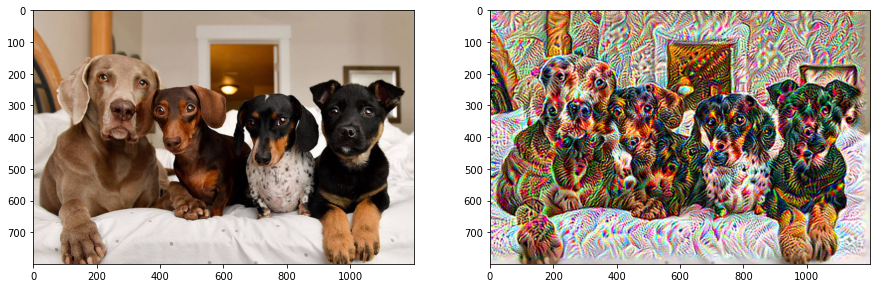

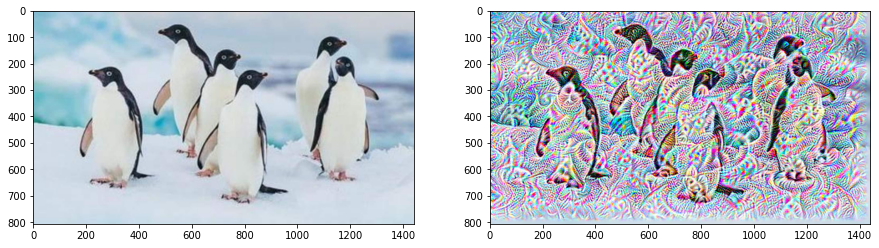

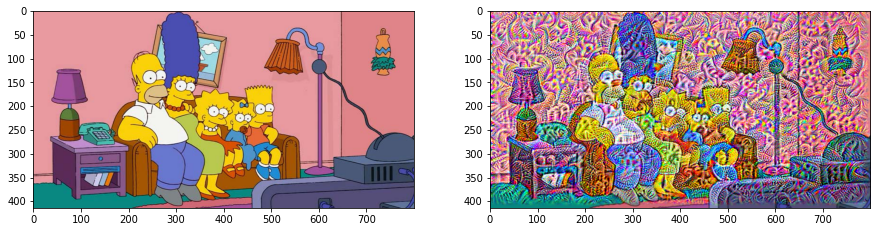

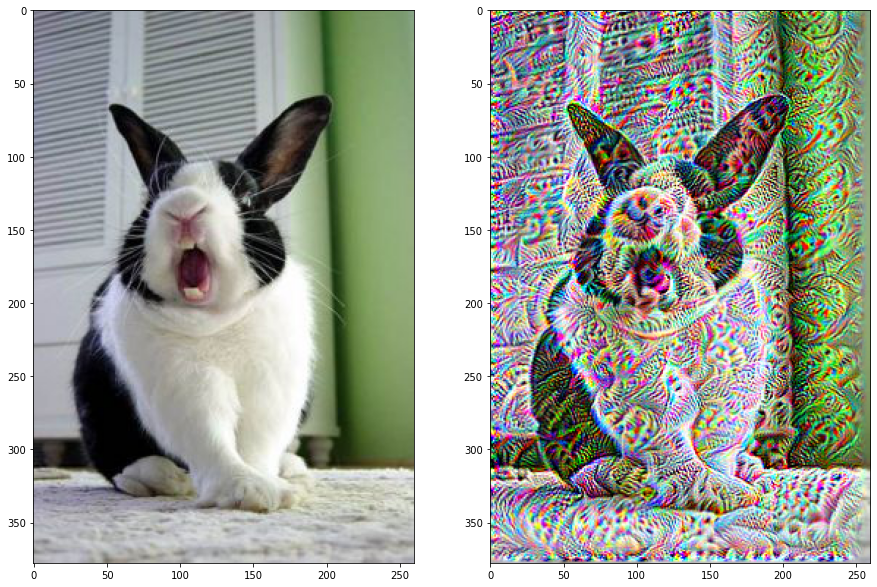

In [8]:
# set up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deep_dream = DeepDream(loi=LOI).to(device).eval()
samples = glob.glob('samples/*')


# run deep dream for all samples
results = []
for sample in samples:
    image = Image.open(sample)
    size = image.size

    # run deep dream
    target = dream_deep(deep_dream, image, device)

    # save result
    result = target.resize(size)
    results.append(result)

    # show results
    _, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    ax[1].imshow(result)
    plt.show()